Fetching 5y of 1d data for AAPL...

Successfully downloaded data for AAPL.

--- Running Stationarity Test (ADF) ---
ADF Statistic: -1.8796
p-value: 0.3417
Conclusion: Data is likely non-stationary (p-value > 0.05).

--- Running Non-Linearity Test (Terasvirta) ---
Terasvirta F-statistic: 1.6024
p-value: 0.0213
Conclusion: Null hypothesis rejected (p-value < 0.05). The data is likely NON-LINEAR.

Model Selected: BiLSTM (due to non-linearity detection)

--- Training Final BiLSTM Model on All Data ---
--- Generating 250-Step Forecast with BiLSTM ---

Test RMSLE (250 steps): 0.0507
Test MAPE: 4.02%


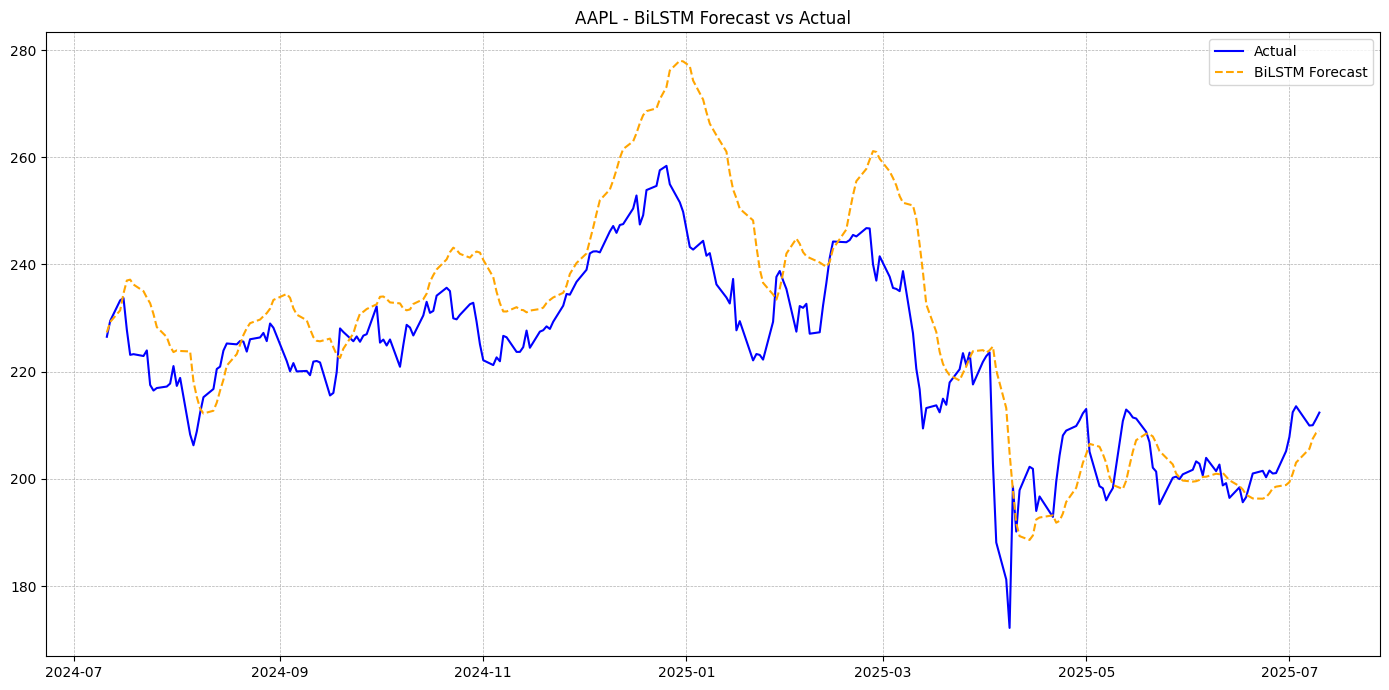

In [6]:
#!/usr/bin/env python
# --- Core Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# --- Statsmodels for classical time series analysis ---
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import f

# --- Scikit-learn for metrics and preprocessing ---
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, root_mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

# --- TensorFlow for Neural Network ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Suppress TensorFlow warnings ---
import os

import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


#
# --- SECTION 1: DATA GATHERING & UTILITY FUNCTIONS ---
#

def get_ohlcv_data(ticker_symbol, period="5y", interval="1d"):
    """Fetches historical OHLCV data for a given stock ticker."""
    try:
        ticker = yf.Ticker(ticker_symbol)
        print(f"Fetching {period} of {interval} data for {ticker_symbol}...")
        data = ticker.history(period=period, interval=interval)
        if data.empty:
            print(f"Error: No data found for ticker '{ticker_symbol}'. It might be an invalid ticker.")
            return None
        return data
    except Exception as e:
        print(f"An error occurred during data fetching: {e}")
        return None


def adf_test(series):
    """Performs the Augmented Dickey-Fuller test for stationarity."""
    print("\n--- Running Stationarity Test (ADF) ---")
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Conclusion: Data is likely stationary (p-value <= 0.05).")
    else:
        print("Conclusion: Data is likely non-stationary (p-value > 0.05).")


def prepare_time_series_data(series, n_lags=3):
    """Converts a time series into a lagged format for regression."""
    df = pd.DataFrame(series)
    df.columns = ['value']
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['value'].shift(lag)
    df = df.dropna()
    y = df['value'].values
    X = df.drop('value', axis=1).values
    return y, X


def terasvirta_non_linearity_test(series, n_lags=3, alpha=0.05):
    """
    Performs the Terasvirta test for non-linearity.
    Null Hypothesis (H0): The model is linear.
    Alternative Hypothesis (H1): The model is non-linear.
    """
    print("\n--- Running Non-Linearity Test (Terasvirta) ---")
    y, X = prepare_time_series_data(series, n_lags)
    X = sm.add_constant(X, has_constant='add')
    n, p = X.shape

    # Step 1: Fit linear model and get residuals (u_hat)
    model_linear = sm.OLS(y, X).fit()
    u_hat = model_linear.resid
    ssr0 = np.sum(u_hat ** 2)

    # Step 2: Create augmented regressors (quadratic and cubic terms)
    quad_terms = [X[:, i] * X[:, j] for i in range(p) for j in range(i, p)]
    cubic_terms = [X[:, i] * X[:, j] * X[:, k] for i in range(p) for j in range(i, p) for k in range(j, p)]
    X_aug = np.column_stack([X] + quad_terms + cubic_terms)
    m = X_aug.shape[1] - X.shape[1]  # Number of added terms

    # Step 3: Regress residuals on augmented regressors and get SSR1
    model_aug = sm.OLS(u_hat, X_aug).fit()
    ssr1 = model_aug.ssr

    # Step 4: Compute the F-statistic
    F_stat = ((ssr0 - ssr1) / m) / (ssr1 / (n - p - m))
    p_value = 1 - f.cdf(F_stat, m, n - p - m)

    print(f"Terasvirta F-statistic: {F_stat:.4f}")
    print(f"p-value: {p_value:.4f}")

    if p_value < alpha:
        print(f"Conclusion: Null hypothesis rejected (p-value < {alpha}). The data is likely NON-LINEAR.")
        return True  # Non-linear
    else:
        print(f"Conclusion: Fail to reject null hypothesis (p-value >= {alpha}). The data is likely LINEAR.")
        return False  # Linear


#
# --- SECTION 2: MAIN EXECUTION BLOCK ---
#

if __name__ == "__main__":
    # --- General Configuration ---
    target_ticker = 'AAPL'
    forecast_start_date = pd.to_datetime("2024-07-11")  # Make sure this date exists in the dataset for exog vars

    # --- 1. Data Gathering and Preparation ---
    ohlcv_df = get_ohlcv_data(target_ticker, period="5y")

    if ohlcv_df is not None:
        print(f"\nSuccessfully downloaded data for {target_ticker}.")
        df = ohlcv_df.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1)
        df = df.reset_index()
        df['Date'] = df['Date'].dt.date
        df = df.set_index('Date')
        df.index = pd.to_datetime(df.index)

        # Define endogenous (target) and exogenous (features) variables
        endog = df['Close']
        exog = df.drop(columns=['Close'])

        # --- 2. Perform Initial Data Analysis ---
        adf_test(endog)
        is_nonlinear = terasvirta_non_linearity_test(endog, n_lags=3)

        # --- 3. Conditional Model Execution ---
        if is_nonlinear:
            # ===============================================================
            # --- OPTION A: RUN BILSTM FOR NON-LINEAR DATA ---
            # ===============================================================
            print("\nModel Selected: BiLSTM (due to non-linearity detection)")

            # --- BiLSTM Configuration ---
            use_log_transform_bilstm = True
            sequence_length = 15
            n_epochs = 100
            batch_size = 32

            # --- Data Transformation ---
            endog_transformed = np.log1p(endog) if use_log_transform_bilstm else endog.copy()
            scaler_endog = MinMaxScaler()
            endog_scaled = scaler_endog.fit_transform(endog_transformed.values.reshape(-1, 1)).flatten()
            scaler_exog = MinMaxScaler()
            exog_scaled = scaler_exog.fit_transform(exog)
            endog_scaled_series = pd.Series(endog_scaled, index=endog_transformed.index)
            exog_scaled_df = pd.DataFrame(exog_scaled, index=exog.index, columns=exog.columns)

            # --- Sequence Generation ---
            def create_sequences(endog_data, exog_data, seq_length):
                X, y = [], []
                for i in range(len(endog_data) - seq_length):
                    endog_seq = endog_data[i:(i + seq_length)]
                    exog_seq = exog_data[i:(i + seq_length)]
                    combined_seq = np.hstack([endog_seq.reshape(-1, 1), exog_seq])
                    X.append(combined_seq)
                    y.append(endog_data[i + seq_length])
                return np.array(X), np.array(y)


            train_end_date = forecast_start_date - pd.Timedelta(days=1)
            train_endog_scaled = endog_scaled_series.loc[:train_end_date]
            train_exog_scaled = exog_scaled_df.loc[:train_end_date]
            X_train, y_train = create_sequences(train_endog_scaled.values, train_exog_scaled.values, sequence_length)

            true_test = endog.loc[forecast_start_date:exog.index[-1]]
            forecast_steps = len(true_test)


            # --- BiLSTM Model ---
            def build_bilstm_model(input_shape):
                model = Sequential([
                    Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=input_shape),
                    Dropout(0.5),
                    Bidirectional(LSTM(50, activation='relu')),
                    Dropout(0.5),
                    Dense(1)
                ])
                model.compile(optimizer='adam', loss='mean_squared_error')
                return model


            # --- Final Model Training ---
            print("\n--- Training Final BiLSTM Model on All Data ---")
            final_model = build_bilstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
            early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
            final_model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, callbacks=[early_stopping],
                            verbose=0)

            # --- Iterative Forecasting ---
            print(f"--- Generating {forecast_steps}-Step Forecast with BiLSTM ---")
            last_sequence = X_train[-1:]
            forecasts_scaled = []
            for i in range(forecast_steps):
                next_pred_scaled = final_model.predict(last_sequence, verbose=0).flatten()[0]
                forecasts_scaled.append(next_pred_scaled)
                next_date_index = true_test.index[i]
                if next_date_index not in exog_scaled_df.index: break
                next_exog_scaled = exog_scaled_df.loc[next_date_index].values
                new_step = np.hstack([next_pred_scaled, next_exog_scaled]).reshape(1, 1, -1)
                last_sequence = np.append(last_sequence[:, 1:, :], new_step, axis=1)

            # --- Inverse Transform and Evaluate ---
            forecast_inv = scaler_endog.inverse_transform(np.array(forecasts_scaled).reshape(-1, 1))
            final_forecast = np.expm1(forecast_inv) if use_log_transform_bilstm else forecast_inv
            final_forecast = np.clip(final_forecast, 0, None).flatten()
            forecast_index = true_test.index[:len(final_forecast)]
            forecast_series = pd.Series(final_forecast, index=forecast_index)
            aligned_true_test = true_test.loc[forecast_series.index]

            # --- Evaluation ---
            test_rmsle = root_mean_squared_log_error(aligned_true_test, forecast_series)
            test_mape = mean_absolute_percentage_error(aligned_true_test, forecast_series)
            print(f"\nTest RMSLE ({len(forecast_series)} steps): {test_rmsle:.4f}")
            print(f"Test MAPE: {test_mape * 100:.2f}%")

            # --- Plotting ---
            plt.figure(figsize=(14, 7))
            plt.plot(aligned_true_test.index, aligned_true_test, label="Actual", color='blue')
            plt.plot(forecast_series.index, forecast_series, label="BiLSTM Forecast", linestyle='--', color='orange')
            plt.title(f"{target_ticker} - BiLSTM Forecast vs Actual")
            plt.legend()
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()

        else:
            #===============================================================
            #--- OPTION B: RUN SARIMAX FOR LINEAR DATA ---
            #===============================================================
            print("\nModel Selected: SARIMAX (due to linearity detection)")

            # --- SARIMAX Configuration ---
            use_log_transform_sarimax = True
            p, d, q = 3, 0, 2
            P, D, Q, s = 2, 1, 1, 7 # Weekly seasonality

            # --- Data Transformation ---
            endog_transformed = np.log1p(endog) if use_log_transform_sarimax else endog.copy()
            train_endog = endog_transformed.copy()
            train_exog = exog.loc[train_endog.index]

            # Define the exact range for forecasting and ground truth
            forecast_exog = exog.loc[forecast_start_date:]
            forecast_steps = len(forecast_exog)
            true_test = endog.loc[forecast_exog.index] # Align true_test to exog range

            # --- Final Model Training ---
            print("\n--- Training Final SARIMAX Model on All Data ---")
            final_model = SARIMAX(train_endog,
                                  exog=train_exog,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
            final_model_fit = final_model.fit(disp=False)
            print("Final model training complete.")

            # --- Forecasting ---
            print(f"--- Generating {forecast_steps}-Step Forecast with SARIMAX ---")
            forecast_log = final_model_fit.forecast(steps=forecast_steps, exog=forecast_exog)

            # Inverse transform
            forecast = np.expm1(forecast_log) if use_log_transform_sarimax else forecast_log
            forecast = pd.Series(np.clip(forecast, 0, None), name='forecast')

            # ------------------- FIX STARTS HERE -------------------
            # Manually assign the correct DatetimeIndex to the forecast series.
            # This is the crucial step to prevent the KeyError.
            forecast.index = forecast_exog.index
            # -------------------- FIX ENDS HERE --------------------

            # --- Evaluation ---
            # Now the indices will align perfectly
            aligned_true_test = true_test.loc[forecast.index]
            test_rmsle = root_mean_squared_log_error(aligned_true_test, forecast)
            test_mape = mean_absolute_percentage_error(aligned_true_test, forecast)
            print(f"\nTest RMSLE ({forecast_steps} steps): {test_rmsle:.4f}")
            print(f"Test MAPE: {test_mape * 100:.2f}%")

            # --- Plotting ---
            plt.figure(figsize=(14, 7))
            plt.plot(aligned_true_test.index, aligned_true_test, label="Actual", color='blue')
            plt.plot(forecast.index, forecast, label="SARIMAX Forecast", linestyle='--', color='red')
            plt.title(f"{target_ticker} - SARIMAX Forecast vs Actual")
            plt.legend()
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()